# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from analysis.bivariate import *
from analysis.hypothesis_testing import *
from analysis.visualization import *
from utils import *

# Data

In [ ]:
df = pd.read_csv(
    r'../../data/',
    encoding='utf-8',
)

In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
df.head()

,temperature,humidity,wind_speed,precipitation_(%),atmospheric_pressure,visibility_(km),cloud_cover,season,location,uv_index,weather_type
0,14.0,73,9.5,82.0,1010.82,3.5,partly cloudy,Winter,inland,2,1
1,39.0,96,8.5,71.0,1011.43,10.0,partly cloudy,Spring,inland,7,0
2,30.0,64,7.0,16.0,1018.72,5.5,clear,Spring,mountain,5,3
3,38.0,83,1.5,82.0,1026.25,1.0,clear,Spring,coastal,7,3
4,27.0,74,17.0,66.0,990.67,2.5,overcast,Winter,mountain,1,1


# Load metadata

In [5]:
df = load_metadata(
    df,
    r"D:\_Dev\My Project\Weather Classification\code\data\metadata\metadata2.json",
)

# Overview

## Check

In [6]:
print(f"Num of varibles:", df.shape[1])
print(f"Num of rows:", df.shape[0])

Num of varibles: 11
Num of rows: 13200


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   temperature           13200 non-null  float64 
 1   humidity              13200 non-null  int64   
 2   wind_speed            13200 non-null  float64 
 3   precipitation_(%)     13200 non-null  float64 
 4   atmospheric_pressure  13200 non-null  float64 
 5   visibility_(km)       13200 non-null  float64 
 6   cloud_cover           13200 non-null  category
 7   season                13200 non-null  category
 8   location              13200 non-null  category
 9   uv_index              13200 non-null  category
 10  weather_type          13200 non-null  category
dtypes: category(5), float64(5), int64(1)
memory usage: 684.7 KB


In [8]:
df.isnull().sum()

temperature             0
humidity                0
wind_speed              0
precipitation_(%)       0
atmospheric_pressure    0
visibility_(km)         0
cloud_cover             0
season                  0
location                0
uv_index                0
weather_type            0
dtype: int64

## Varibles and target

In [9]:
target = ['weather_type']
variablies = [col for col in df.columns if col not in target]

print(target)
print(variablies)

['weather_type']
['temperature', 'humidity', 'wind_speed', 'precipitation_(%)', 'atmospheric_pressure', 'visibility_(km)', 'cloud_cover', 'season', 'location', 'uv_index']


# Grouping Varibles by their respective data types (except target)

In [10]:
numerical_cols, categorical_cols, date_cols= group_columns_by_type(df[variablies], display_info=True)

Total numeric columns: 6
Numeric columns: ['temperature', 'humidity', 'wind_speed', 'precipitation_(%)', 'atmospheric_pressure', 'visibility_(km)']

Total categorical columns: 4
Categorical columns: ['cloud_cover', 'season', 'location', 'uv_index']



# Bivariate

**The analysis focuses exclusively on the relationship between numerical and categorical variables with target**

## Numerical - Categorical

### Distribution

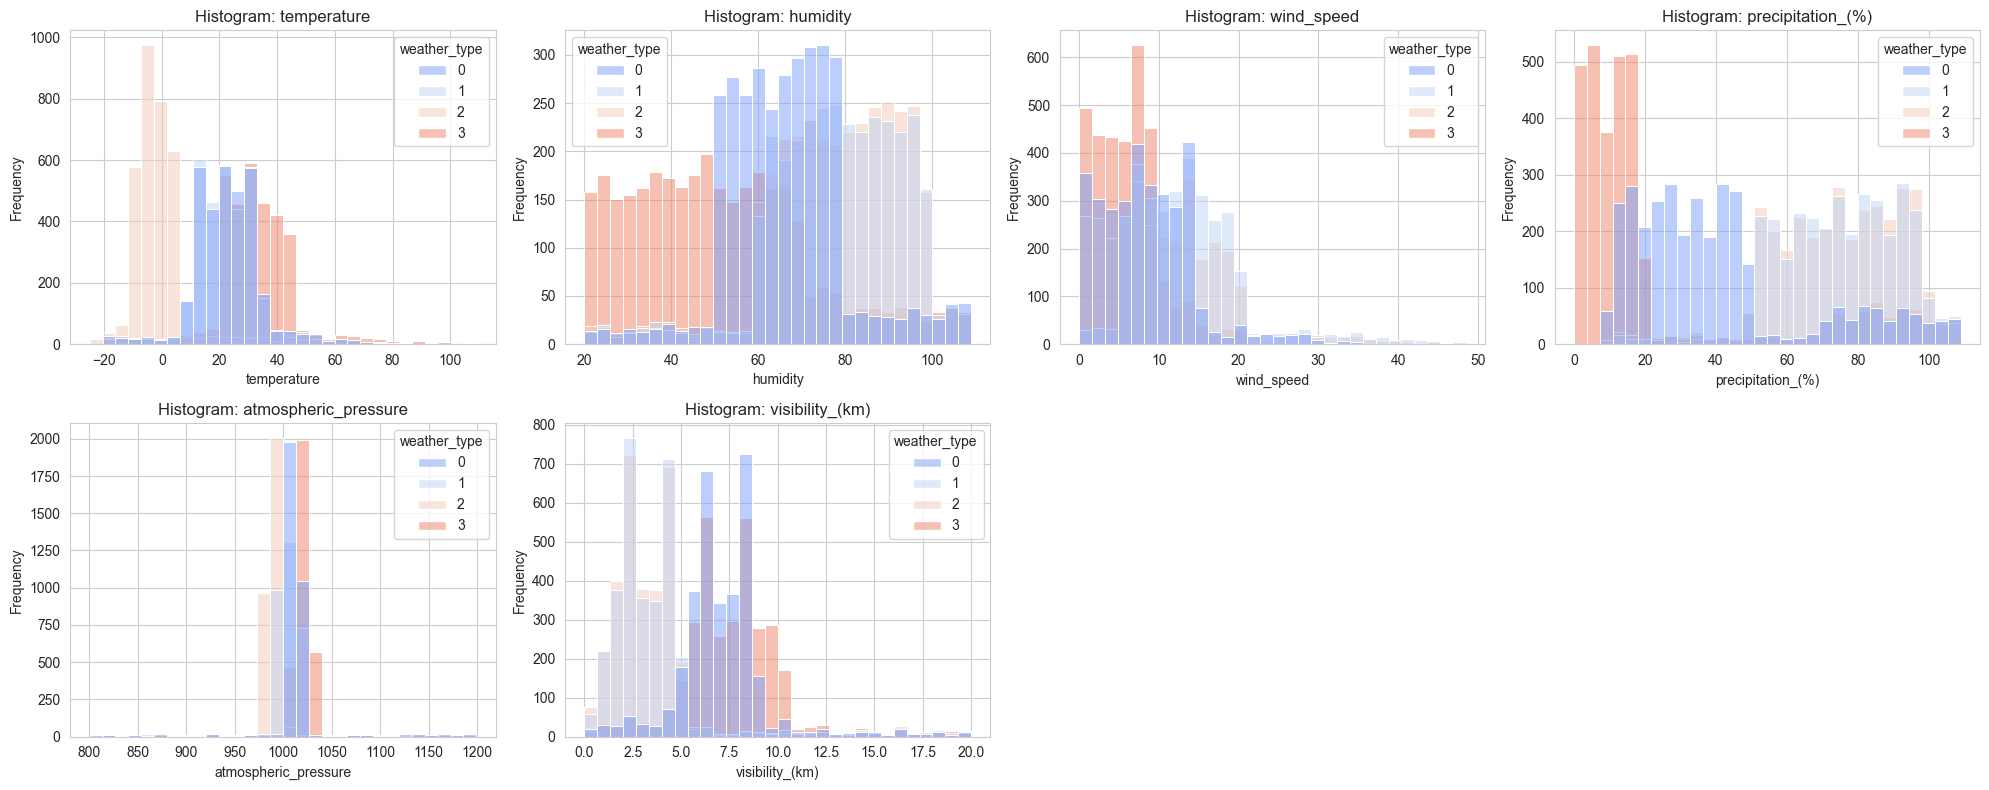

In [11]:
plot_multiple_histograms(df, numerical_cols, kde=False, hue=target[0], bins=30, palette="coolwarm", n_cols=4)

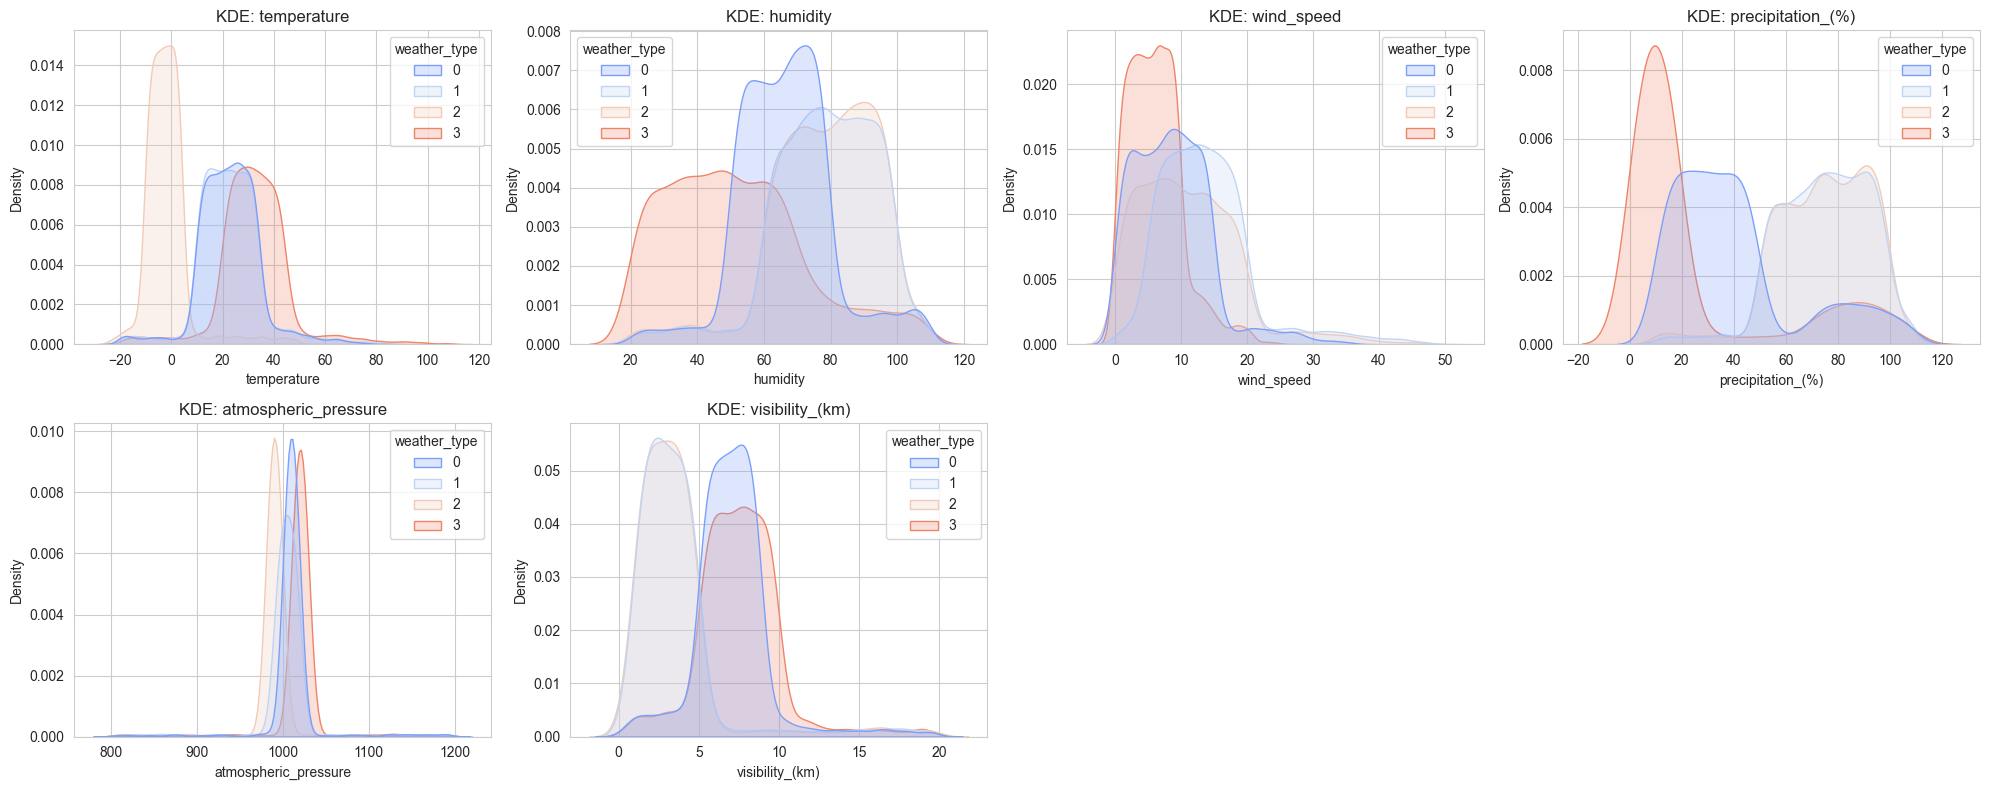

In [12]:
plot_multiple_kdeplots(df, numerical_cols, hue=target[0], fill=True, palette="coolwarm", n_cols=4)

### Hypothesis

#### T-test

In [13]:
if df[target[0]].nunique() == 2:
    for col in numerical_cols:
        t_test(df, col, target[0])
        print()

#### Mann–Whitney U test

In [14]:
if df[target[0]].nunique() == 2:
    for col in numerical_cols:
        mann_whitney_u_test(df, col, target[0])
        print()

#### Anova test

In [15]:
if df[target[0]].nunique() > 2:
    for col in numerical_cols:
        anova_test(df, col, target[0])
        print()

                    ANOVA TEST: temperature vs weather_type                     
Assumption Checks:
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed
Error: ANOVA assumptions (normality and homogeneity) not met.

                      ANOVA TEST: humidity vs weather_type                      
Assumption Checks:
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed
Error: ANOVA assumptions (normality and homogeneity) not met.

                     ANOVA TEST: wind_speed vs weather_type                     
Assumption Checks:
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed
Error: ANOVA assumptions (normality and homogeneity) not met.

                 ANOVA TEST: precipitation_(%) vs weather_type                  
Assumption Checks:
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed
Error: ANOVA assumptions (normality and homogeneity) not met.

                ANOVA TEST: atmospheric_

#### Kruskal-Wallis test

In [16]:
if df[target[0]].nunique() > 1:
    for col in numerical_cols:
        kruskal_wallis_test(df, col, target[0])
        print()

                KRUSKAL-WALLIS TEST: temperature vs weather_type                
Assumption Checks (Informational):
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed

Test Results:
- Test Type: Kruskal-Wallis
- H-statistic: 6836.8426
- P-value: 0.0000

Interpretation:
- Significant difference (p-value < 0.05).


                 KRUSKAL-WALLIS TEST: humidity vs weather_type                  
Assumption Checks (Informational):
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed

Test Results:
- Test Type: Kruskal-Wallis
- H-statistic: 4034.5980
- P-value: 0.0000

Interpretation:
- Significant difference (p-value < 0.05).


                KRUSKAL-WALLIS TEST: wind_speed vs weather_type                 
Assumption Checks (Informational):
- Normality (Shapiro-Wilk): ✗ Failed
- Homogeneity (Levene's Test): ✗ Failed

Test Results:
- Test Type: Kruskal-Wallis
- H-statistic: 2513.5842
- P-value: 0.0000

Interpretation:
- Significant differen

## Categorical - Categorical

### Distribution

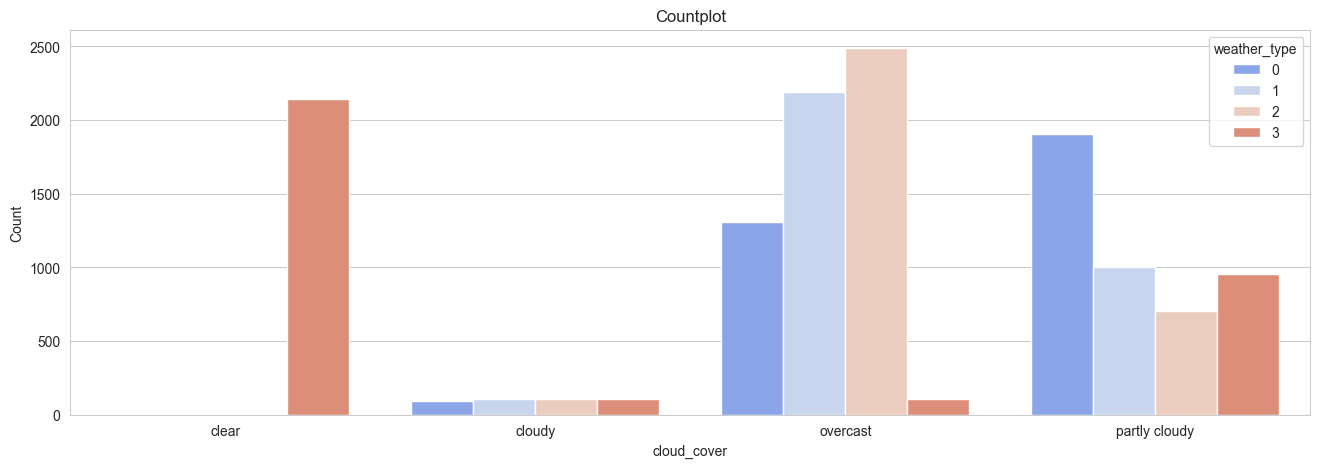

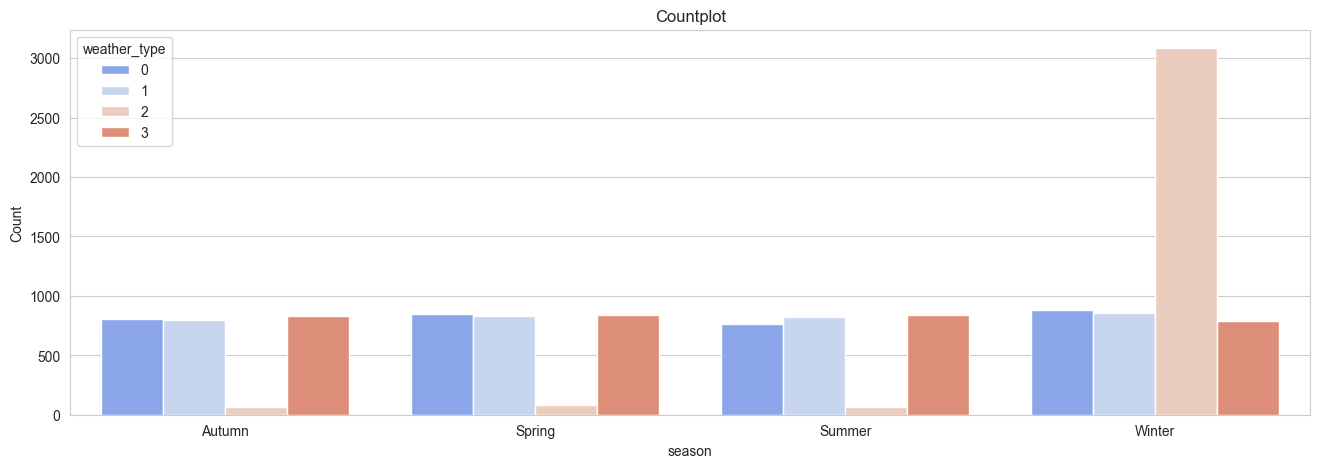

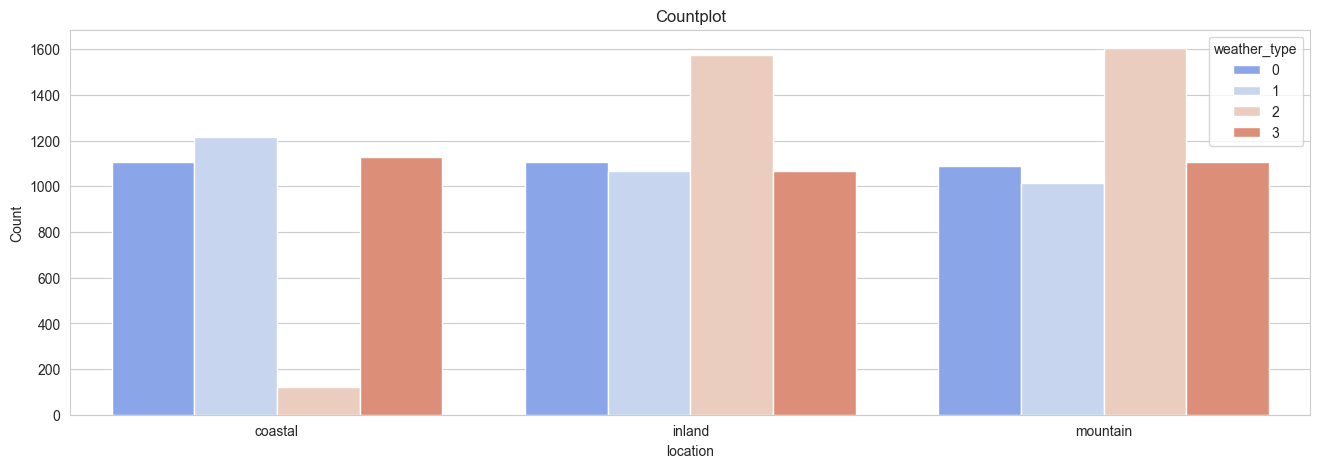

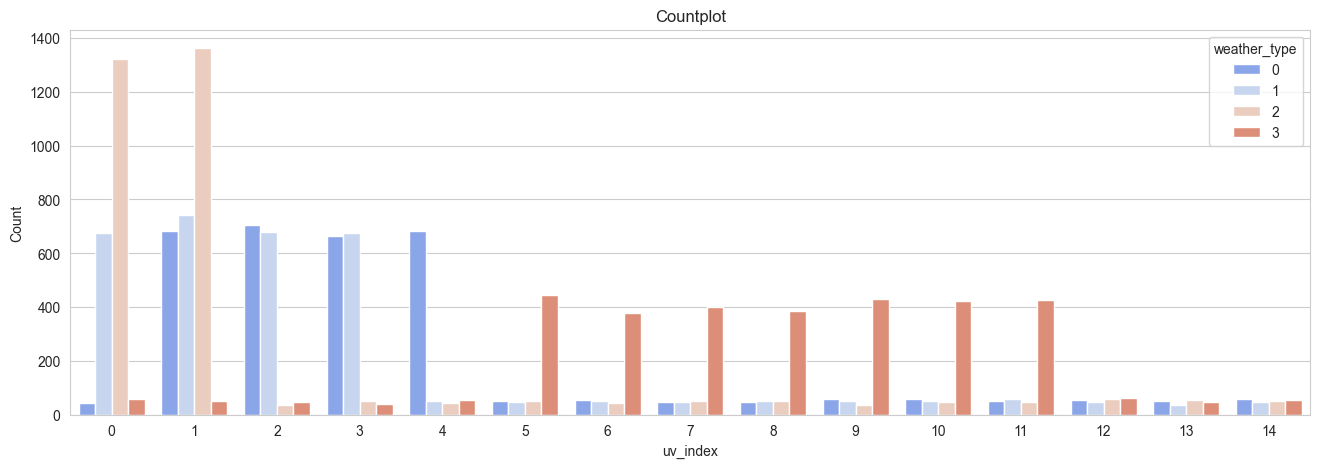

In [17]:
for col in categorical_cols:
    plot_countplot(df, col, hue=target[0], palette="coolwarm", figsize=(16,5))

In [18]:
for col in categorical_cols:
    print(pd.crosstab(df[col], df[target[0]], normalize=False))
    print('='*50)
    print()

weather_type      0     1     2     3
cloud_cover                          
clear             0     0     0  2139
cloudy           92   105   107   107
overcast       1305  2193  2489   103
partly cloudy  1903  1002   704   951

weather_type    0    1     2    3
season                           
Autumn        806  796    69  829
Spring        850  831    80  837
Summer        766  820    65  841
Winter        878  853  3086  793

weather_type     0     1     2     3
location                            
coastal       1106  1216   120  1129
inland        1107  1069  1575  1065
mountain      1087  1015  1605  1106

weather_type    0    1     2    3
uv_index                         
0              44  675  1320   58
1             682  743  1363   49
2             704  677    36   48
3             665  675    51   41
4             683   50    43   55
5              50   45    52  444
6              53   50    43  378
7              45   45    52  401
8              46   52    49  385
9     

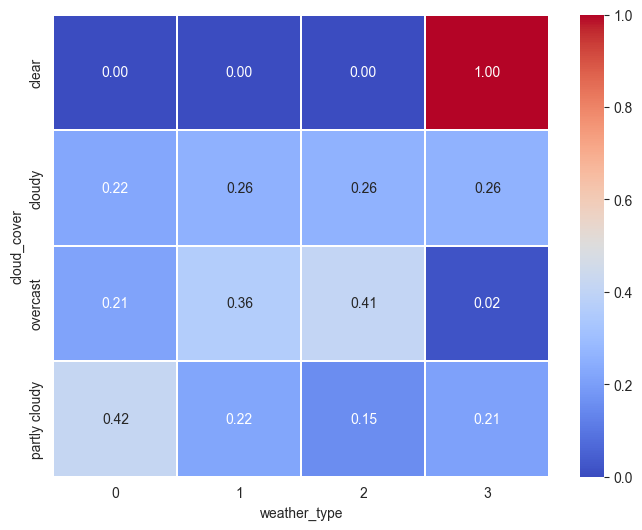

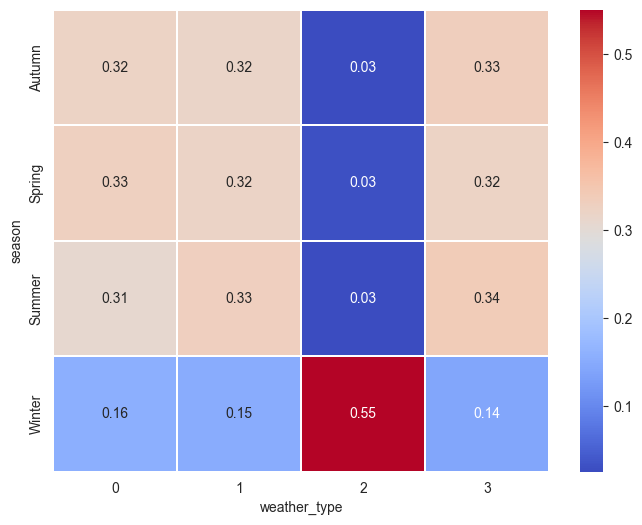

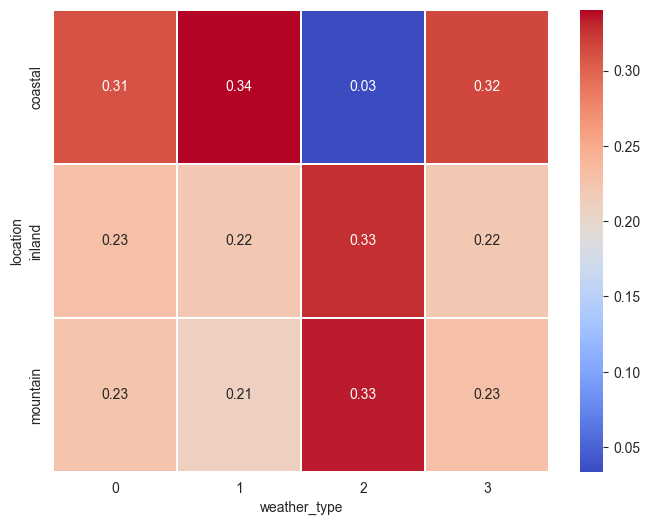

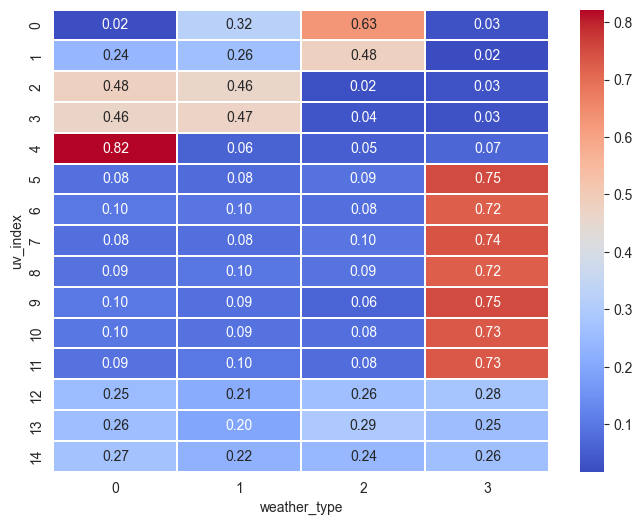

In [19]:
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df[target[0]], normalize="index")
    plt.figure(figsize=(8,6))
    sns.heatmap(contingency_table, cmap="coolwarm", fmt=".2f", annot=True, linewidths=0.3)

### Hypothesis

#### Chi-square test

In [20]:
for col in categorical_cols:
    chi2_test(df, col, target[0])
    print()

                  CHI-SQUARE TEST: cloud_cover vs weather_type                  
Test Results:
- Test Type: Chi-square test of independence
- Chi2 Statistic: 9407.3593
- Degrees of freedom: 9
- P-value: 0.0000

Interpretation:
- Dependent (p-value < 0.05)


                    CHI-SQUARE TEST: season vs weather_type                     
Test Results:
- Test Type: Chi-square test of independence
- Chi2 Statistic: 4694.8048
- Degrees of freedom: 9
- P-value: 0.0000

Interpretation:
- Dependent (p-value < 0.05)


                   CHI-SQUARE TEST: location vs weather_type                    
Test Results:
- Test Type: Chi-square test of independence
- Chi2 Statistic: 1235.3829
- Degrees of freedom: 6
- P-value: 0.0000

Interpretation:
- Dependent (p-value < 0.05)


                   CHI-SQUARE TEST: uv_index vs weather_type                    
Test Results:
- Test Type: Chi-square test of independence
- Chi2 Statistic: 11965.8351
- Degrees of freedom: 42
- P-value: 0.0000

Interpretatio

#### Cramér's V

In [21]:
for col in categorical_cols:
    cramers_v_test(df, col, target[0])
    print()

                    CRAMÉR'S V: cloud_cover vs weather_type                     
Cramér's V: 0.4874


                       CRAMÉR'S V: season vs weather_type                       
Cramér's V: 0.3443


                      CRAMÉR'S V: location vs weather_type                      
Cramér's V: 0.2163


                      CRAMÉR'S V: uv_index vs weather_type                      
Cramér's V: 0.5497




### CA (Corresponding Analysis)

In [22]:
print(categorical_cols)
print(target)

['cloud_cover', 'season', 'location', 'uv_index']
['weather_type']


In [23]:
df_for_ca = df[categorical_cols + target]

#### Caculate inertia for each pairs

In [24]:
df_ca_inertia_pairs = calculate_ca_inertia_pairs(df_for_ca, n_components=2)

In [25]:
df_ca_inertia_pairs

,variable_1,variable_2,inertia,n_modal_1,n_modal_2
0,uv_index,weather_type,0.906503,15,4
1,cloud_cover,weather_type,0.712679,4,4
2,cloud_cover,uv_index,0.458966,4,15
3,season,weather_type,0.355667,4,4
4,season,uv_index,0.148114,4,15
5,location,weather_type,0.093590,3,4
6,cloud_cover,season,0.062536,4,4
7,season,location,0.041527,4,3
8,location,uv_index,0.033237,3,15
9,cloud_cover,location,0.014953,4,3


In [26]:
df_ca_inertia_pairs[(df_ca_inertia_pairs['variable_1'] == target[0]) | (df_ca_inertia_pairs['variable_2'] == target[0])].sort_values(by='inertia', ascending=False).reset_index()

,index,variable_1,variable_2,inertia,n_modal_1,n_modal_2
0,0,uv_index,weather_type,0.906503,15,4
1,1,cloud_cover,weather_type,0.712679,4,4
2,3,season,weather_type,0.355667,4,4
3,5,location,weather_type,0.093590,3,4


#### Analysis deeper

In [27]:
var1 = categorical_cols[-1]
var2 = target[0]

In [28]:
contingency_table = pd.crosstab(df.loc[:,var1], df.loc[:, var2])
contingency_table

weather_type,0,1,2,3
uv_index,,,,
0,44,675,1320,58
1,682,743,1363,49
2,704,677,36,48
3,665,675,51,41
4,683,50,43,55
5,50,45,52,444
6,53,50,43,378
7,45,45,52,401
8,46,52,49,385


In [29]:
ca = CA(n_components=2, n_iter=10, copy=True, check_input=True, engine='sklearn', random_state=42)
ca = ca.fit(contingency_table)

In [30]:
ca.plot(
    contingency_table,
    x_component=0,
    y_component=1,
    show_row_markers=True,
    show_column_markers=True,
    show_row_labels=False,
    show_column_labels=False
)

alt.LayerChart(...)

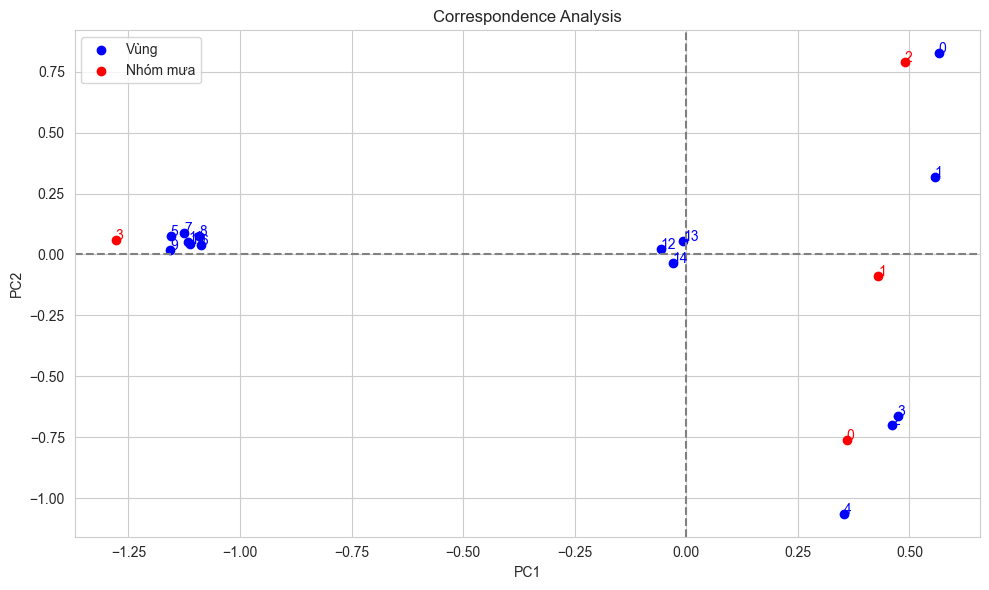

In [31]:
row_coords = ca.row_coordinates(contingency_table)
col_coords = ca.column_coordinates(contingency_table)

plt.figure(figsize=(10,6))
plt.scatter(row_coords[0], row_coords[1], color='blue', label='Vùng')
for i, label in enumerate(row_coords.index):
    plt.text(row_coords.iloc[i, 0], row_coords.iloc[i, 1], label, color='blue')

plt.scatter(col_coords[0], col_coords[1], color='red', marker='o', label='Nhóm mưa')
for i, label in enumerate(col_coords.index):
    plt.text(col_coords.iloc[i, 0], col_coords.iloc[i, 1], label, color='red')

plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle='--', color='gray')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Correspondence Analysis")
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
ca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.547,60.35%,60.35%
1,0.304,33.52%,93.87%


In [33]:
ca.row_contributions_.style.format('{:.3%}')

,0,1
0,9.302%,35.591%
1,12.189%,7.102%
2,4.325%,17.831%
3,4.450%,15.669%
4,1.442%,23.426%
5,10.921%,0.088%
6,8.592%,0.021%
7,9.514%,0.106%
8,8.773%,0.073%
9,10.582%,0.004%


In [34]:
ca.column_contributions_.style.format('{:.3%}')

,0,1
0,5.897%,47.678%
1,8.454%,0.638%
2,10.940%,51.397%
3,74.709%,0.286%


# Save

In [35]:
df = pd.concat([df[numerical_cols+categorical_cols+date_cols+target]], axis=1)

## Metadata `.json`

In [ ]:
save_metadata(
    df,
    "",
)

## To `.csv`

In [ ]:
df.to_csv(
    r"",
    index=False,
    encoding="utf-8",
)